In [1]:
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
import torch

import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from cleaning.pipeline import strategic_fill, shift_forecast_columns

# Clean Apartment Data

Merge apartment demand data into single CSVs for each year.

In [2]:
project_root = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
from pathlib import Path
import datetime

def combine_csv_files_with_datetime(year_dir, year):
    """
    Combines all CSV files in a directory into a single DataFrame with aligned datetime index.
    Each CSV file becomes a column in the resulting DataFrame.
    Handles duplicate timestamps by taking their mean value.
    """
    csv_files = list(Path(year_dir).glob('*.csv'))
    if not csv_files:
        return None
    
    # Initialize dictionary to store DataFrames
    dfs = {}
    all_dates = set()
    
    # First pass: read all files and collect all unique dates
    for file_path in csv_files:
        col_name = file_path.stem
        try:
            # Read CSV assuming first column is datetime and second is demand
            df = pd.read_csv(file_path)
            
            # Convert first column to datetime
            df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
            
            # Create temporary DataFrame and handle duplicates by taking mean
            temp_df = pd.DataFrame({
                'datetime': df.iloc[:, 0],
                col_name: df.iloc[:, 1]
            })
            # Group by datetime and take mean of duplicates
            temp_df = temp_df.groupby('datetime')[col_name].mean()
            
            dfs[col_name] = temp_df
            
            # Add dates to our set of all dates
            all_dates.update(temp_df.index)
            
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue
    
    if not dfs:
        return None
    
    
    # Create a complete datetime index for the year
    start_date = min(all_dates)
    end_date = max(all_dates)
    complete_index = pd.date_range(start=start_date, end=end_date, freq='15min')
    
    # Create final DataFrame with complete datetime index
    final_df = pd.DataFrame(index=complete_index)
    
    # Add each apartment's data
    for col_name, series in dfs.items():
        final_df[col_name] = series.reindex(complete_index)
    
    # Reset index to make datetime a column named 'time' (changed from 'timestamp')
    final_df.reset_index(names=['time'], inplace=True)
    
    return final_df

base_dir = os.path.join(project_root, 'data', 'raw_data', 'umass_smart', 'apartment')

for year in ['2014', '2015', '2016']:
    year_dir = os.path.join(base_dir, year)
    
    # Combine CSV files for the year
    combined_df = combine_csv_files_with_datetime(year_dir, year)
    
    if combined_df is not None:
        # Create output filename
        output_file = os.path.join(base_dir, f"raw_apartment_{year}.csv")
        
        # Save combined DataFrame to CSV
        combined_df.to_csv(output_file, index=False)
        print(f"Created {output_file} with {len(combined_df.columns)-1} apartment columns")
        print(f"Date range: {combined_df['time'].min()} to {combined_df['time'].max()}")
    else:
        print(f"No CSV files found in {year_dir}")

/var/folders/bz/8k18ft7x11n_w6ks_k5dq1gr0000gn/T/ipykernel_16841/3247007530.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[col_name] = series.reindex(complete_index)
/var/folders/bz/8k18ft7x11n_w6ks_k5dq1gr0000gn/T/ipykernel_16841/3247007530.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[col_name] = series.reindex(complete_index)
/var/folders/bz/8k18ft7x11n_w6ks_k5dq1gr0000gn/T/ipykernel_16841/3247007530.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

Created /Users/aryanahri/epf_datasets/data/raw_data/umass_smart/apartment/raw_apartment_2014.csv with 108 apartment columns
Date range: 2014-08-14 16:30:00 to 2014-12-31 23:45:00


/var/folders/bz/8k18ft7x11n_w6ks_k5dq1gr0000gn/T/ipykernel_16841/3247007530.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[col_name] = series.reindex(complete_index)
/var/folders/bz/8k18ft7x11n_w6ks_k5dq1gr0000gn/T/ipykernel_16841/3247007530.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[col_name] = series.reindex(complete_index)
/var/folders/bz/8k18ft7x11n_w6ks_k5dq1gr0000gn/T/ipykernel_16841/3247007530.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

Created /Users/aryanahri/epf_datasets/data/raw_data/umass_smart/apartment/raw_apartment_2015.csv with 114 apartment columns
Date range: 2015-01-01 00:15:00 to 2015-12-31 23:45:00


KeyboardInterrupt: 

Fill in missing values in each of the merged raw files.

In [3]:
raw_dirs = [os.path.join(project_root, 'data', 'raw_data', 'umass_smart', 'apartment', 'raw_apartment_2014.csv'), 
             os.path.join(project_root, 'data', 'raw_data', 'umass_smart', 'apartment', 'raw_apartment_2015.csv'), 
             os.path.join(project_root, 'data', 'raw_data', 'umass_smart', 'apartment', 'raw_apartment_2016.csv')]
filled_dfs = [None, None, None]
years = [2014, 2015, 2016]

In [ ]:
for i, year in enumerate(years):
    curr_df = filled_dfs[i]
    curr_df = pd.read_csv(raw_dirs[i])
    print("Rows in raw df:", len(curr_df))

    curr_df['time'] = pd.to_datetime(curr_df['time'], utc=True)
    
    # Set the index to the 'time' column
    curr_df = curr_df.set_index('time')
    # print(curr_df.head())
    
    start_time = curr_df.index.min()
    end_time = curr_df.index.max()
    complete_range = pd.date_range(start=start_time, end=end_time, freq='15min')

    # Find missing hours and then insert these times to make the time consecutive
    missing_hours = complete_range.difference(curr_df.index)
    print(missing_hours)
    missing_df = pd.DataFrame(index=missing_hours)
    curr_df = pd.concat([curr_df, missing_df])
    curr_df = curr_df.sort_index()
    
    curr_df = strategic_fill(curr_df)
    
    missing_hours = complete_range.difference(curr_df.index)
    print(missing_hours)
    print("Rows in filled df:", len(curr_df))
    filled_dfs[i] = curr_df

Rows in raw df: 13374
DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='15min')
DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='15min')
Rows in filled df: 13374
Rows in raw df: 35039
DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='15min')
DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='15min')
Rows in filled df: 35039
Rows in raw df: 34841
DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='15min')
DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='15min')
Rows in filled df: 34841


In [5]:
for df in filled_dfs:
    print(f"Number of columns in dataframe: {len(df.columns)}")

Number of columns in dataframe: 108
Number of columns in dataframe: 114
Number of columns in dataframe: 114


In [ ]:
for df in filled_dfs:
    print(f"Total NaN values in dataframe: {df.isna().sum().sum()}")

Total NaN values in dataframe: 0
Total NaN values in dataframe: 0
Total NaN values in dataframe: 0


Vertically stack the DFs

In [ ]:
# Strip the year suffix from column names in each dataframe
for i, df in enumerate(filled_dfs):
    # Get the corresponding year
    year = years[i]
    
    # Create a dictionary to rename columns
    rename_dict = {}
    for col in df.columns:
        # Remove the year suffix from column names
        new_col = col.replace(f'_{year}', '')
        rename_dict[col] = new_col
    
    # Rename the columns
    filled_dfs[i] = df.rename(columns=rename_dict)
    
    print(f"Renamed columns for {year} data, sample columns: {list(filled_dfs[i].columns)[:5]}")


Renamed columns for 2014 data, sample columns: ['Apt36', 'Apt37', 'Apt41', 'Apt40', 'Apt104']
Renamed columns for 2015 data, sample columns: ['Apt105', 'Apt104', 'Apt40', 'Apt41', 'Apt37']
Renamed columns for 2016 data, sample columns: ['Apt90', 'Apt91', 'Apt75', 'Apt74', 'Apt104']


In [8]:
final_df = pd.DataFrame(columns=filled_dfs[1].columns)


In [9]:
# Make a copy to avoid fragmentation warnings
df_copy = filled_dfs[2].copy()

# Get the current index
current_index = df_copy.index

# Create a new index shifted back by 1 minute
new_index = current_index - pd.Timedelta(minutes=1)

# Set the new index
df_copy.index = new_index

# Update the dataframe in the list
filled_dfs[2] = df_copy

print(f"Shifted datetime indices for filled_dfs[2] back by 1 minute")
print(f"Original first index: {current_index[0]}, New first index: {new_index[0]}")


Shifted datetime indices for filled_dfs[2] back by 1 minute
Original first index: 2016-01-01 00:01:00+00:00, New first index: 2016-01-01 00:00:00+00:00


In [ ]:
# Create a list to store all dataframes
all_dfs = []

# Process each dataframe to ensure consistent columns
for i, df in enumerate(filled_dfs):
    # Make a copy to avoid fragmentation warnings
    df_copy = df.copy()
    all_dfs.append(df_copy)
    print(f"Added dataframe {i} with shape {df_copy.shape}")

# Concatenate all dataframes vertically (row-wise) while preserving datetime index
final_df = pd.concat(all_dfs, axis=0, ignore_index=False)

# Sort by the datetime index
final_df = final_df.sort_index()

# Remove duplicate indices if any, keeping the first occurrence
final_df = final_df[~final_df.index.duplicated(keep='first')]

print(f"Final dataframe shape: {final_df.shape}")
print(f"Time range: {final_df.index.min()} to {final_df.index.max()}")


Added dataframe 0 with shape (13374, 108)
Added dataframe 1 with shape (35039, 114)
Added dataframe 2 with shape (34841, 114)
Final dataframe shape: (83254, 114)
Time range: 2014-08-14 16:30:00+00:00 to 2016-12-28 22:00:00+00:00


In [11]:
final_df.columns

Index(['Apt36', 'Apt37', 'Apt41', 'Apt40', 'Apt104', 'Apt105', 'Apt75',
       'Apt74', 'Apt90', 'Apt91',
       ...
       'Apt89', 'Apt88', 'Apt52', 'Apt53', 'Apt112', 'Apt21', 'Apt6', 'Apt65',
       'Apt3', 'Apt94'],
      dtype='object', length=114)

In [12]:
# Count the number of NaN values in the entire DataFrame
total_nan_count = final_df.isna().sum().sum()
print(f"Total number of NaN values in the DataFrame: {total_nan_count}")

# Count NaN values per column
nan_counts_by_column = final_df.isna().sum()
print("\nNaN values per column:")
print(nan_counts_by_column)

# Calculate percentage of NaN values in the DataFrame
total_cells = final_df.size
nan_percentage = (total_nan_count / total_cells) * 100
print(f"\nPercentage of NaN values: {nan_percentage:.2f}%")


Total number of NaN values in the DataFrame: 80244

NaN values per column:
Apt36         0
Apt37         0
Apt41         0
Apt40         0
Apt104        0
          ...  
Apt21     13374
Apt6      13374
Apt65     13374
Apt3      13374
Apt94     13374
Length: 114, dtype: int64

Percentage of NaN values: 0.85%


In [13]:
final_df.head()

,Apt36,Apt37,Apt41,Apt40,Apt104,Apt105,Apt75,Apt74,Apt90,Apt91,...,Apt89,Apt88,Apt52,Apt53,Apt112,Apt21,Apt6,Apt65,Apt3,Apt94
time,,,,,,,,,,,,,,,,,,,,,
2014-08-14 16:30:00+00:00,0.778088,0.889862,0.0,0.626588,0.0,0.296489,0.0,1.206508,0.0,0.568082,...,0.0,0.0,0.323794,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-14 16:45:00+00:00,0.090972,0.889862,0.0,0.626588,0.0,0.296489,0.0,1.206508,0.0,0.568082,...,0.0,0.0,0.323794,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-14 17:00:00+00:00,0.026297,0.889862,0.0,0.626588,0.0,0.296489,0.0,1.206508,0.0,0.568082,...,0.0,0.0,0.323794,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-14 17:15:00+00:00,0.756447,0.889862,0.0,0.626588,0.0,0.296489,0.0,1.206508,0.0,0.568082,...,0.0,0.0,0.323794,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-14 17:30:00+00:00,0.340047,0.889862,0.0,0.626588,0.0,0.296489,0.0,1.206508,0.0,0.568082,...,0.0,0.0,0.323794,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
len(final_df)

83254

In [15]:
start_time = final_df.index.min()
end_time = final_df.index.max()
complete_range = pd.date_range(start=start_time, end=end_time, freq='15min')

missing_hours = complete_range.difference(final_df.index)
print(missing_hours)
missing_df = pd.DataFrame(index=missing_hours)
final_df = pd.concat([final_df, missing_df])
final_df = final_df.sort_index()  

filled_final_df = strategic_fill(final_df)

missing_hours = complete_range.difference(filled_final_df.index)
print(missing_hours)

DatetimeIndex(['2015-01-01 00:00:00+00:00'], dtype='datetime64[ns, UTC]', freq='15min')
DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='15min')


In [16]:
len(filled_final_df)

83255

In [ ]:
# Count the number of NaN values in the filled DataFrame
filled_total_nan_count = filled_final_df.isna().sum().sum()
print(f"Total number of NaN values in the filled DataFrame: {filled_total_nan_count}")

# Calculate percentage of NaN values in the filled DataFrame
filled_total_cells = filled_final_df.size
filled_nan_percentage = (filled_total_nan_count / filled_total_cells) * 100
print(f"Percentage of NaN values in filled DataFrame: {filled_nan_percentage:.2f}%")

# Count NaN values per column in the filled DataFrame
filled_nan_counts_by_column = filled_final_df.isna().sum()
print("\nTop 10 columns with most NaN values:")
print(filled_nan_counts_by_column.sort_values(ascending=False).head(10))


Total number of NaN values in the filled DataFrame: 0
Percentage of NaN values in filled DataFrame: 0.00%

Top 10 columns with most NaN values:
Apt36     0
Apt95     0
Apt71     0
Apt39     0
Apt38     0
Apt98     0
Apt106    0
Apt107    0
Apt99     0
Apt43     0
dtype: int64


In [18]:
# Extract time features from the index
filled_final_df['HoD'] = filled_final_df.index.hour
filled_final_df['DoW'] = filled_final_df.index.dayofweek
filled_final_df['MoY'] = filled_final_df.index.month

print("Added time features to the dataframe:")
print(f"Hour of day (HoD): values from 0-23")
print(f"Day of week (DoW): values from 0-6, where 0 is Monday and 6 is Sunday")
print(f"Month of year (MoY): values from 1-12")
print("\nDataframe shape after adding features:", filled_final_df.shape)


Added time features to the dataframe:
Hour of day (HoD): values from 0-23
Day of week (DoW): values from 0-6, where 0 is Monday and 6 is Sunday
Month of year (MoY): values from 1-12

Dataframe shape after adding features: (83255, 117)


In [ ]:
# Calculate aggregate consumption (sum across all apartments at each timestep)
# First, get only the apartment columns (excluding the time features we just added)
apartment_columns = filled_final_df.columns[:-3]  # Exclude HoD, DoW, MoY

# Calculate the sum across all apartments for each timestep
filled_final_df['aggregate_consumption'] = filled_final_df[apartment_columns].sum(axis=1)

# Calculate the average consumption across all apartments for each timestep
filled_final_df['average_consumption'] = filled_final_df[apartment_columns].mean(axis=1)

print("Added aggregate and average consumption features:")
print(f"'aggregate consumption': Sum of all apartment consumptions at each timestep")
print(f"'average consumption': Average consumption across all apartments at each timestep")
print("\nDataframe shape after adding consumption features:", filled_final_df.shape)


Added aggregate and average consumption features:
'aggregate consumption': Sum of all apartment consumptions at each timestep
'average consumption': Average consumption across all apartments at each timestep

Dataframe shape after adding consumption features: (83255, 119)


In [20]:
filled_final_df.head()

,Apt36,Apt37,Apt41,Apt40,Apt104,Apt105,Apt75,Apt74,Apt90,Apt91,...,Apt21,Apt6,Apt65,Apt3,Apt94,HoD,DoW,MoY,aggregate_consumption,average_consumption
2014-08-14 16:30:00+00:00,0.778088,0.889862,0.0,0.626588,0.0,0.296489,0.0,1.206508,0.0,0.568082,...,1.295804,0.242049,1.323722,0.944523,1.343416,16,3,8,30.393154,0.266607
2014-08-14 16:45:00+00:00,0.090972,0.889862,0.0,0.626588,0.0,0.296489,0.0,1.206508,0.0,0.568082,...,1.295804,0.242049,1.323722,0.944523,1.343416,16,3,8,33.750332,0.296056
2014-08-14 17:00:00+00:00,0.026297,0.889862,0.0,0.626588,0.0,0.296489,0.0,1.206508,0.0,0.568082,...,1.295804,0.242049,1.323722,0.944523,1.343416,17,3,8,33.049621,0.289909
2014-08-14 17:15:00+00:00,0.756447,0.889862,0.0,0.626588,0.0,0.296489,0.0,1.206508,0.0,0.568082,...,1.295804,0.242049,1.323722,0.944523,1.343416,17,3,8,29.566657,0.259357
2014-08-14 17:30:00+00:00,0.340047,0.889862,0.0,0.626588,0.0,0.296489,0.0,1.206508,0.0,0.568082,...,1.295804,0.242049,1.323722,0.944523,1.343416,17,3,8,30.226490,0.265145


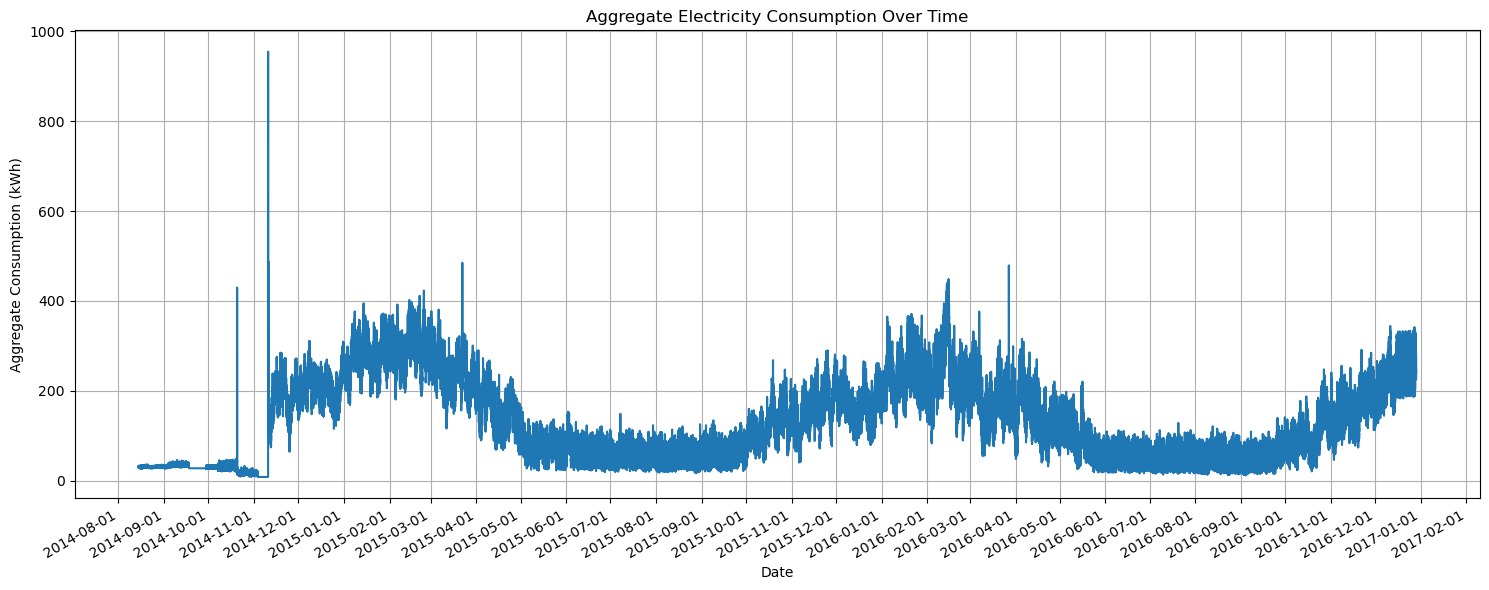

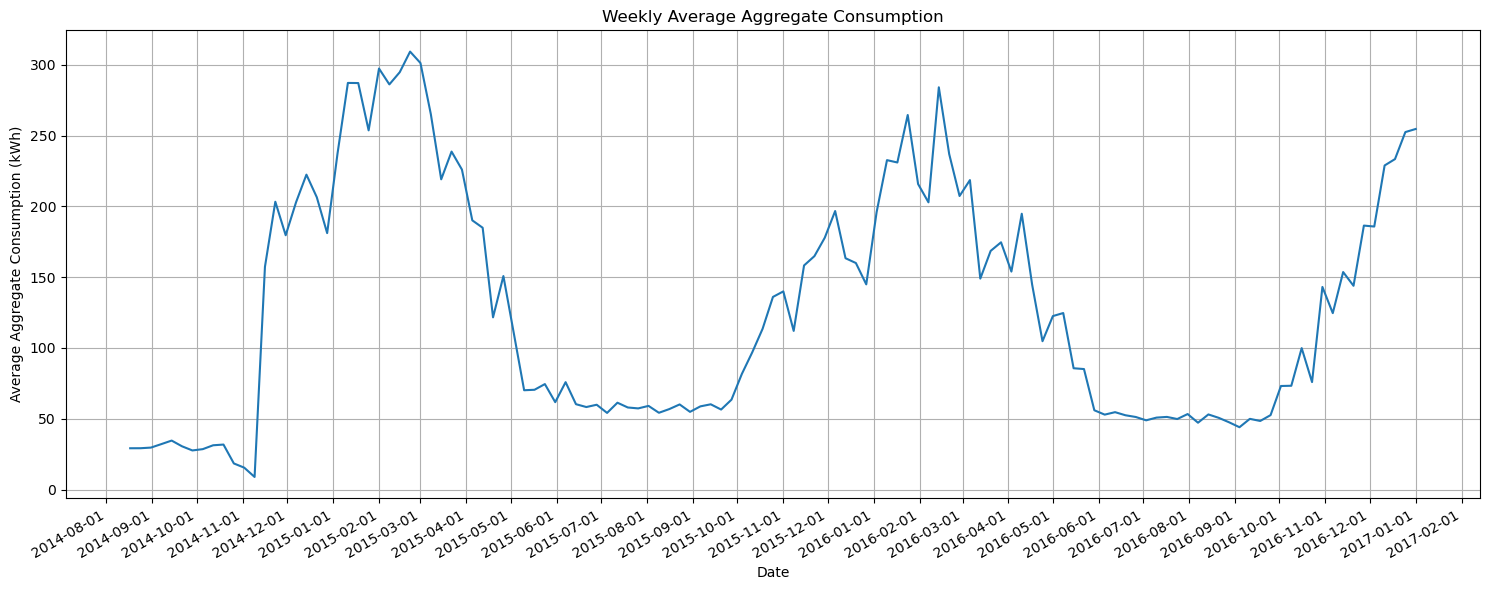

In [ ]:
# Plot the aggregate consumption over time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.plot(filled_final_df.index, filled_final_df['aggregate_consumption'])
plt.title('Aggregate Electricity Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Aggregate Consumption (kWh)')
plt.grid(True)

# Format the x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels

plt.tight_layout()
plt.show()

# Also plot a weekly average to see patterns
weekly_avg = filled_final_df['aggregate_consumption'].resample('W').mean()

plt.figure(figsize=(15, 6))
plt.plot(weekly_avg.index, weekly_avg)
plt.title('Weekly Average Aggregate Consumption')
plt.xlabel('Date')
plt.ylabel('Average Aggregate Consumption (kWh)')
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


Checking for missing values in the time series...
Number of missing values: 0

Performing seasonal decomposition...


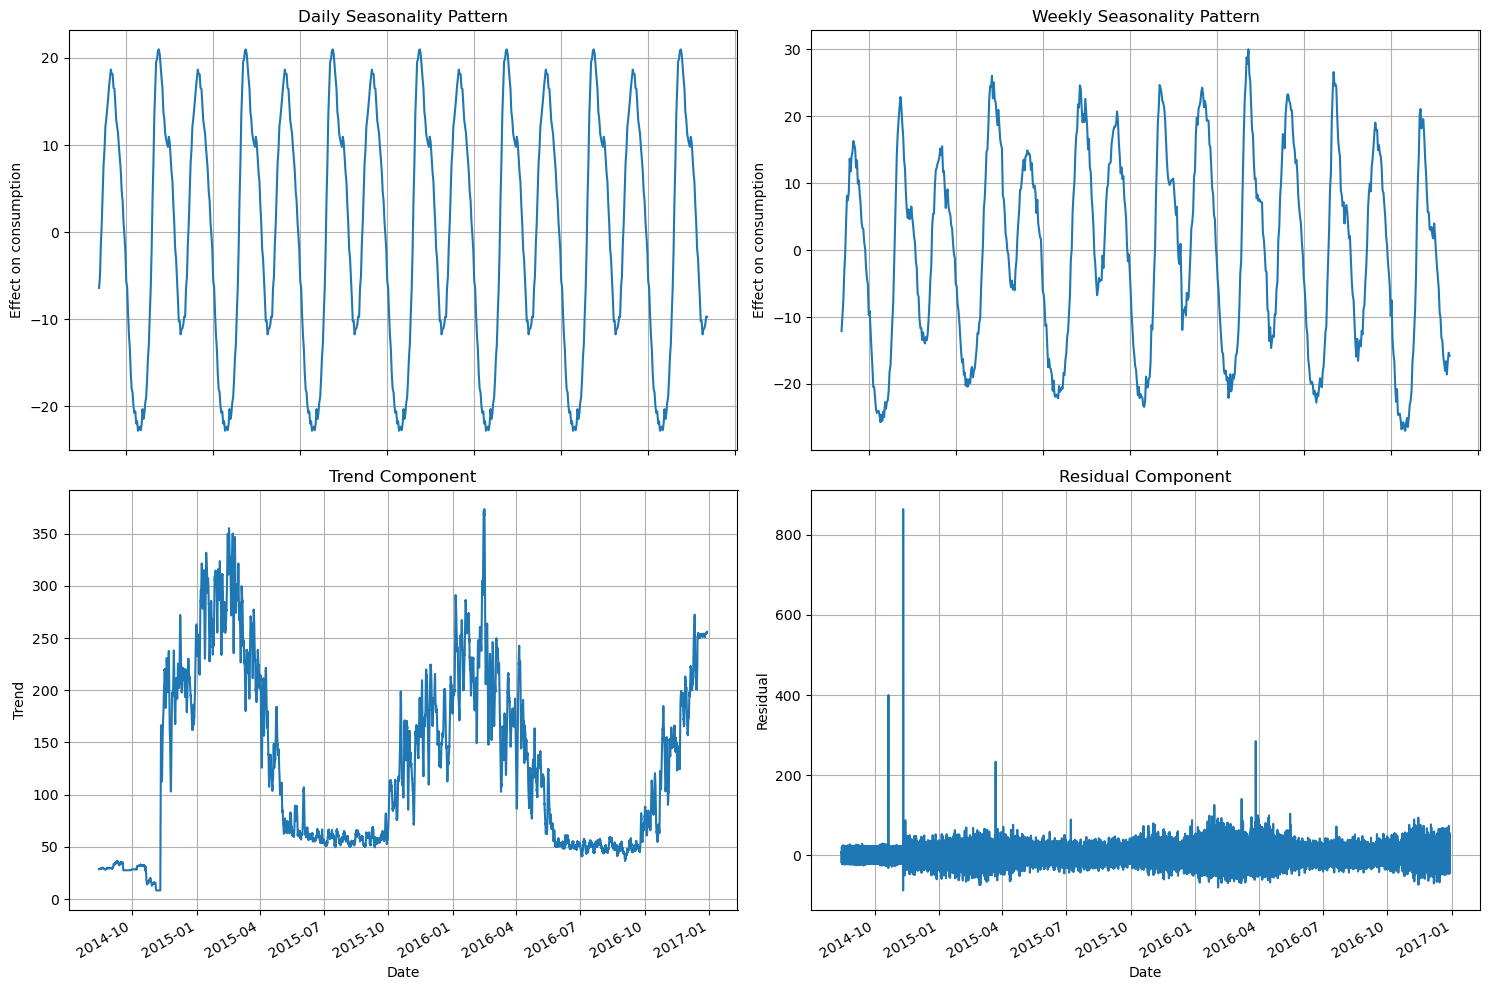


Performing spectral analysis...


/var/folders/bz/8k18ft7x11n_w6ks_k5dq1gr0000gn/T/ipykernel_15561/2615013154.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  consumption_data = filled_final_df['aggregate_consumption'].fillna(method='ffill').values


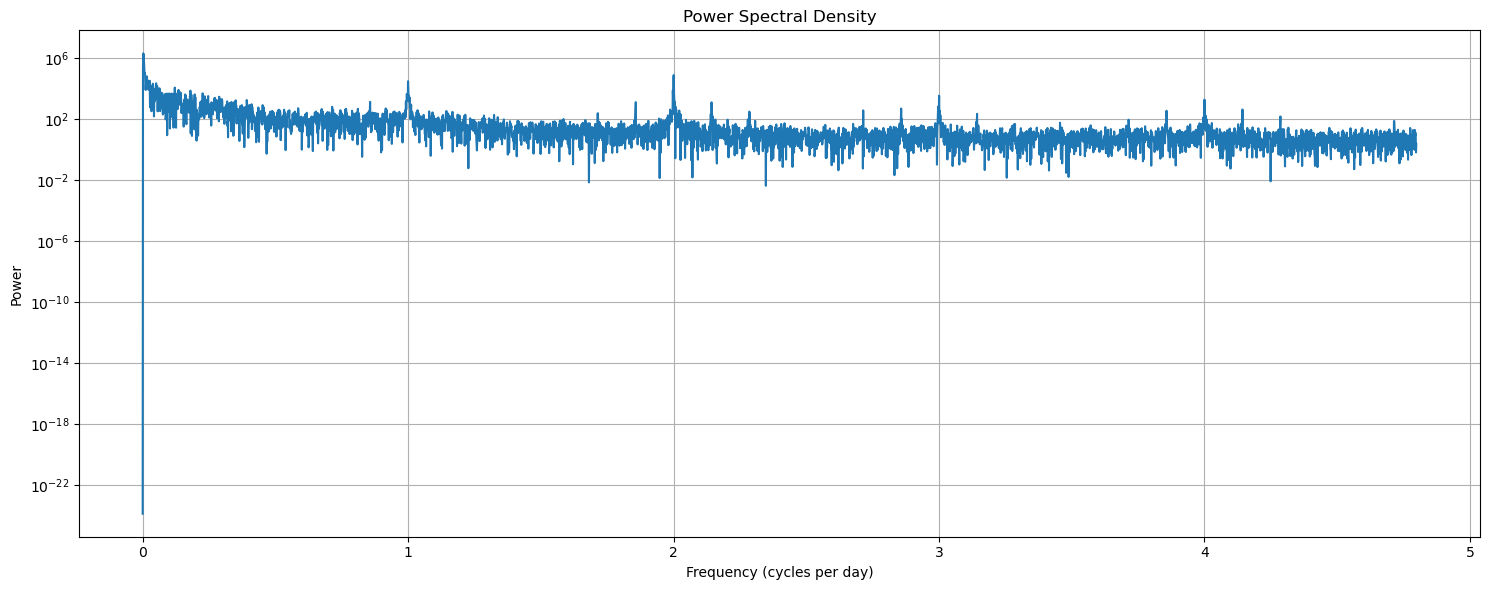

In [ ]:
# Analyze periodicity and seasonality in the aggregate consumption data
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

# Ensure the data is regularly sampled
print("Checking for missing values in the time series...")
print(f"Number of missing values: {filled_final_df['aggregate_consumption'].isna().sum()}")

# Perform seasonal decomposition
# For 15-minute data, we can use different frequencies:
# - 96 for daily seasonality (96 points per day with 15-min intervals)
# - 672 for weekly seasonality (96 * 7)
print("\nPerforming seasonal decomposition...")

# Daily seasonality (96 points per day)
daily_decomposition = seasonal_decompose(
    filled_final_df['aggregate_consumption'], 
    model='additive', 
    period=96,  # 24 hours * 4 (15-min intervals)
    extrapolate_trend='freq'
)

# Weekly seasonality
weekly_decomposition = seasonal_decompose(
    filled_final_df['aggregate_consumption'], 
    model='additive', 
    period=96*7,  # 7 days * 24 hours * 4 (15-min intervals)
    extrapolate_trend='freq'
)

# Plot the decompositions
plt.figure(figsize=(15, 10))

# Daily decomposition
plt.subplot(2, 2, 1)
plt.plot(daily_decomposition.seasonal[:96*7])  # Plot one week of daily seasonality
plt.title('Daily Seasonality Pattern')
plt.xlabel('15-minute intervals')
plt.ylabel('Effect on consumption')
plt.grid(True)

# Weekly decomposition
plt.subplot(2, 2, 2)
plt.plot(weekly_decomposition.seasonal[:96*7])  # Plot one week of weekly seasonality
plt.title('Weekly Seasonality Pattern')
plt.xlabel('15-minute intervals')
plt.ylabel('Effect on consumption')
plt.grid(True)

# Trend component
plt.subplot(2, 2, 3)
plt.plot(daily_decomposition.trend)
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.grid(True)
plt.gcf().autofmt_xdate()

# Residual component
plt.subplot(2, 2, 4)
plt.plot(daily_decomposition.resid)
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Perform spectral analysis to identify dominant frequencies
print("\nPerforming spectral analysis...")
# Use Fourier transform to identify dominant frequencies
consumption_data = filled_final_df['aggregate_consumption'].fillna(method='ffill').values
f, Pxx = signal.periodogram(consumption_data, fs=96)  # 96 samples per day

plt.figure(figsize=(15, 6))
plt.semilogy(f[:len(f)//10], Pxx[:len(Pxx)//10])  # Plot only the first 10% of frequencies
plt.title('Power Spectral Density')
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Power')
plt.grid(True)
plt.tight_layout()
plt.show()


Statistical properties of aggregate consumption:
Mean: 128.1290 kW
Median: 104.9727 kW
Standard Deviation: 87.8610 kW
Minimum: 8.2933 kW
Maximum: 954.9832 kW
Range: 946.6899 kW

Percentiles:
5th percentile: 26.7234 kW
25th percentile: 52.7256 kW
50th percentile: 104.9727 kW
75th percentile: 196.5333 kW
95th percentile: 289.2751 kW
99th percentile: 340.5367 kW


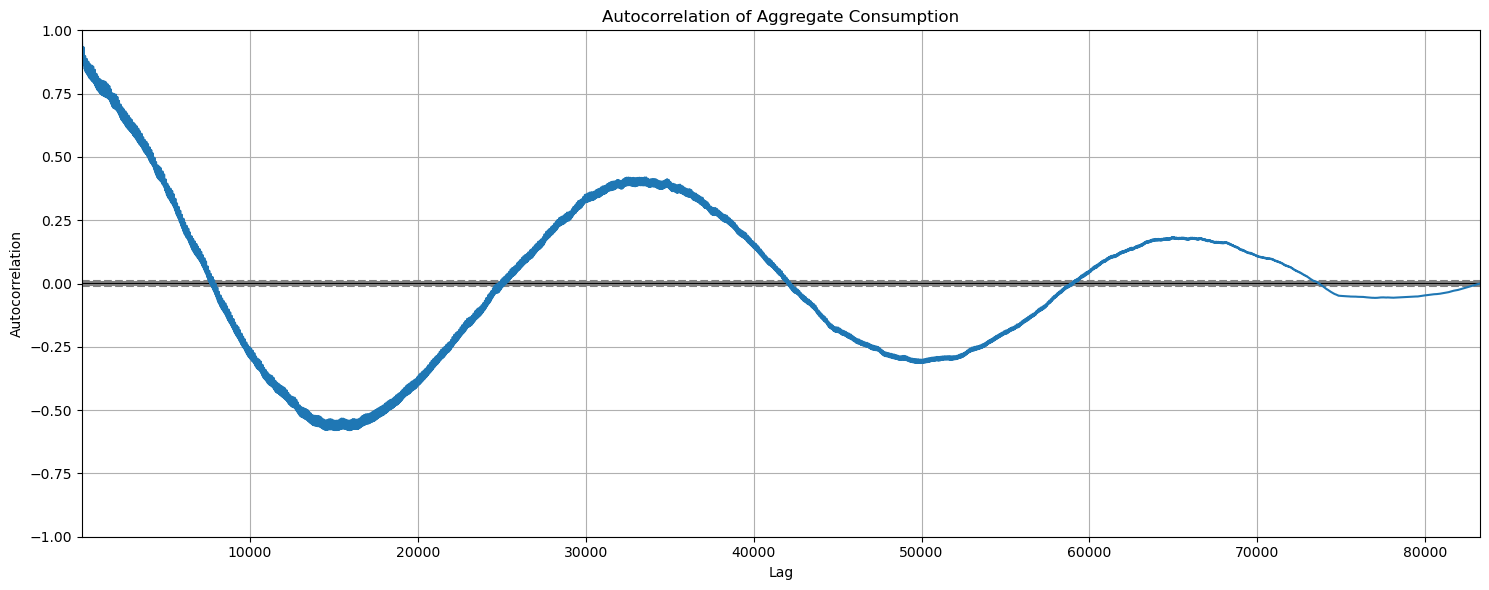

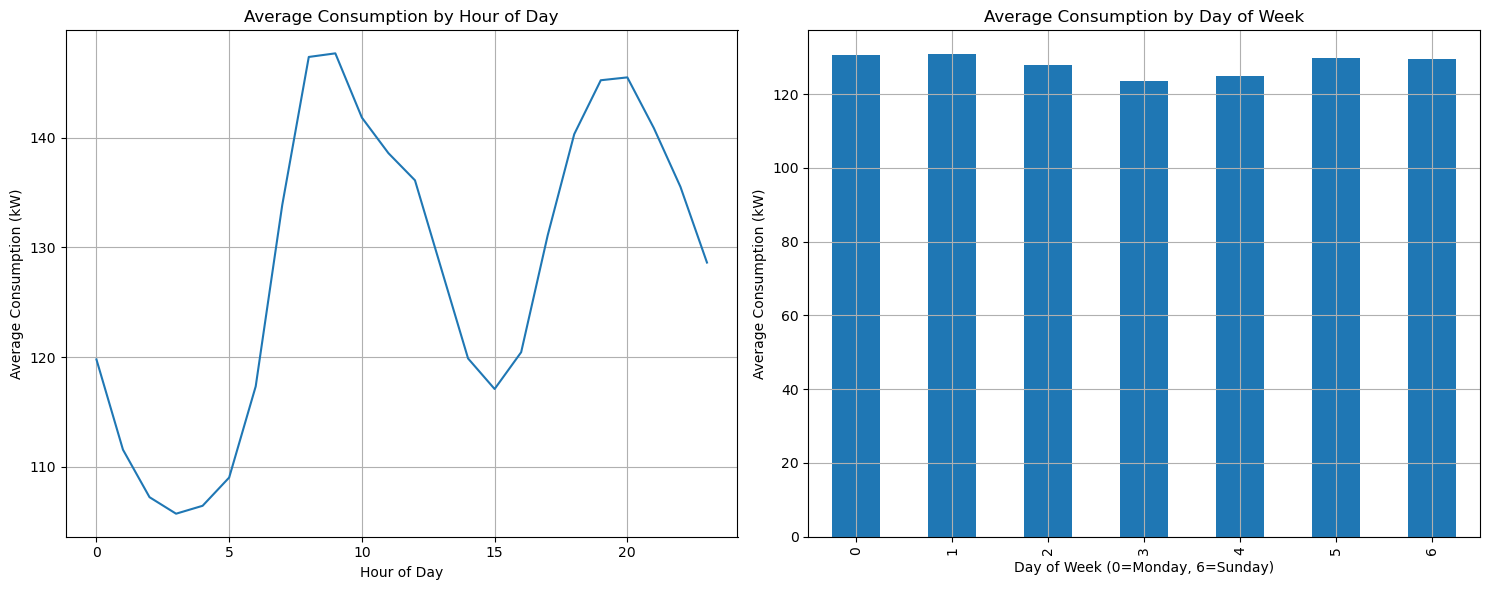

In [24]:
# Extract statistical properties of the aggregate demand
print("\nStatistical properties of aggregate consumption:")
agg_consumption = filled_final_df['aggregate_consumption']

# Basic statistics
print(f"Mean: {agg_consumption.mean():.4f} kW")
print(f"Median: {agg_consumption.median():.4f} kW")
print(f"Standard Deviation: {agg_consumption.std():.4f} kW")
print(f"Minimum: {agg_consumption.min():.4f} kW")
print(f"Maximum: {agg_consumption.max():.4f} kW")
print(f"Range: {agg_consumption.max() - agg_consumption.min():.4f} kW")

# Percentiles
print("\nPercentiles:")
for p in [5, 25, 50, 75, 95, 99]:
    print(f"{p}th percentile: {agg_consumption.quantile(p/100):.4f} kW")

# Autocorrelation analysis
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
autocorrelation_plot(agg_consumption.dropna())
plt.title('Autocorrelation of Aggregate Consumption')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate daily and weekly statistics
daily_avg = filled_final_df.groupby('HoD')['aggregate_consumption'].mean()
weekly_avg = filled_final_df.groupby('DoW')['aggregate_consumption'].mean()

# Plot daily pattern
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
daily_avg.plot(kind='line')
plt.title('Average Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Consumption (kW)')
plt.grid(True)

# Plot weekly pattern
plt.subplot(1, 2, 2)
weekly_avg.plot(kind='bar')
plt.title('Average Consumption by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Consumption (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

output_path = '../data/cleaned/cleaned_umass_smart_apartments.csv'

# Create directory if it doesn't exist
import os
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Save to CSV
filled_final_df.to_csv(output_path)
print(f"Saved cleaned data to {output_path}")


Saved cleaned data to ../data/cleaned/cleaned_umass_smart_apartments.csv


# Clean Weather Data

In [3]:
# Load weather data for 2014, 2015, and 2016
import pandas as pd

# Define the years we want to process
years = [2014, 2015, 2016]

# Dictionary to store the dataframes
weather_dfs = {}

# Load each year's weather data
for year in years:
    # Construct the file path
    file_path = f'../data/raw_data/umass_smart/apartment-weather/apartment{year}.csv'
    
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Set the 'time' column as the index
        if 'time' in df.columns:
            df.set_index('time', inplace=True)
        
        # Store the dataframe in our dictionary
        weather_dfs[year] = df
        
        print(f"Loaded weather data for {year}: {df.shape[0]} rows, {df.shape[1]} columns")
    except FileNotFoundError:
        print(f"Warning: Weather data file for {year} not found at {file_path}")
    except Exception as e:
        print(f"Error loading weather data for {year}: {str(e)}")

# Display the first few rows of each dataframe
for year, df in weather_dfs.items():
    print(f"\nPreview of {year} weather data:")
    print(df.head())


Loaded weather data for 2014: 8784 rows, 13 columns
Loaded weather data for 2015: 8784 rows, 13 columns
Loaded weather data for 2016: 8784 rows, 13 columns

Preview of 2014 weather data:
            temperature         icon  humidity  visibility summary  \
time                                                                 
1388552400        19.76  clear-night      0.48        10.0   Clear   
1388556000        18.74  clear-night      0.49        10.0   Clear   
1388559600        17.40  clear-night      0.53        10.0   Clear   
1388563200        16.94  clear-night      0.54        10.0   Clear   
1388566800        15.51  clear-night      0.60        10.0   Clear   

            apparentTemperature  pressure  windSpeed  cloudCover  windBearing  \
time                                                                            
1388552400                 7.42   1020.07      11.96         0.0          280   
1388556000                 7.44   1024.01       9.78         0.0          280  

In [4]:
# Count NaN values in each weather dataframe
df = weather_dfs[2014]
nan_counts = df.isna().sum()
total_cells = df.size
nan_percentage = (nan_counts.sum() / total_cells) * 100

print(f"\nNaN counts for {2014} weather data:")
print(nan_counts)
print(f"Total NaN values: {nan_counts.sum()} out of {total_cells} cells ({nan_percentage:.2f}%)")

# Count NaN values by column
print("\nNaN percentage by column:")
column_nan_percentage = (nan_counts / df.shape[0]) * 100
for column, percentage in column_nan_percentage.items():
    print(f"{column}: {percentage:.2f}%")



NaN counts for 2014 weather data:
temperature               0
icon                      0
humidity                  0
visibility                0
summary                   0
apparentTemperature       0
pressure                  0
windSpeed                 0
cloudCover             1332
windBearing               0
precipIntensity           0
dewPoint                  0
precipProbability         0
dtype: int64
Total NaN values: 1332 out of 114192 cells (1.17%)

NaN percentage by column:
temperature: 0.00%
icon: 0.00%
humidity: 0.00%
visibility: 0.00%
summary: 0.00%
apparentTemperature: 0.00%
pressure: 0.00%
windSpeed: 0.00%
cloudCover: 15.16%
windBearing: 0.00%
precipIntensity: 0.00%
dewPoint: 0.00%
precipProbability: 0.00%


In [5]:
# Count NaN values in each weather dataframe
df = weather_dfs[2015]
nan_counts = df.isna().sum()
total_cells = df.size
nan_percentage = (nan_counts.sum() / total_cells) * 100

print(f"\nNaN counts for {2015} weather data:")
print(nan_counts)
print(f"Total NaN values: {nan_counts.sum()} out of {total_cells} cells ({nan_percentage:.2f}%)")

# Count NaN values by column
print("\nNaN percentage by column:")
column_nan_percentage = (nan_counts / df.shape[0]) * 100
for column, percentage in column_nan_percentage.items():
    print(f"{column}: {percentage:.2f}%")



NaN counts for 2015 weather data:
temperature               0
icon                      0
humidity                  0
visibility                0
summary                   0
apparentTemperature       0
pressure                  1
windSpeed                 1
cloudCover             1020
windBearing               1
precipIntensity           0
dewPoint                  0
precipProbability         0
dtype: int64
Total NaN values: 1023 out of 114192 cells (0.90%)

NaN percentage by column:
temperature: 0.00%
icon: 0.00%
humidity: 0.00%
visibility: 0.00%
summary: 0.00%
apparentTemperature: 0.00%
pressure: 0.01%
windSpeed: 0.01%
cloudCover: 11.61%
windBearing: 0.01%
precipIntensity: 0.00%
dewPoint: 0.00%
precipProbability: 0.00%


In [6]:
# Count NaN values in each weather dataframe
df = weather_dfs[2016]
nan_counts = df.isna().sum()
total_cells = df.size
nan_percentage = (nan_counts.sum() / total_cells) * 100

print(f"\nNaN counts for {2016} weather data:")
print(nan_counts)
print(f"Total NaN values: {nan_counts.sum()} out of {total_cells} cells ({nan_percentage:.2f}%)")

# Count NaN values by column
print("\nNaN percentage by column:")
column_nan_percentage = (nan_counts / df.shape[0]) * 100
for column, percentage in column_nan_percentage.items():
    print(f"{column}: {percentage:.2f}%")



NaN counts for 2016 weather data:
temperature               0
icon                      0
humidity                  0
visibility                0
summary                   0
apparentTemperature       0
pressure                  0
windSpeed                 0
cloudCover             1057
windBearing               0
precipIntensity           0
dewPoint                  0
precipProbability         0
dtype: int64
Total NaN values: 1057 out of 114192 cells (0.93%)

NaN percentage by column:
temperature: 0.00%
icon: 0.00%
humidity: 0.00%
visibility: 0.00%
summary: 0.00%
apparentTemperature: 0.00%
pressure: 0.00%
windSpeed: 0.00%
cloudCover: 12.03%
windBearing: 0.00%
precipIntensity: 0.00%
dewPoint: 0.00%
precipProbability: 0.00%


In [7]:
# Convert epoch time to datetime in weather dataframes
print("Converting epoch time to datetime in weather dataframes...")

for year, df in weather_dfs.items():
    # Check if the index is already a datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        # Convert epoch time (seconds since 1970-01-01) to datetime
        df.index = pd.to_datetime(df.index, unit='s')
        weather_dfs[year] = df
        print(f"Converted index for {year} weather data to datetime")
    else:
        print(f"Index for {year} weather data is already datetime")

# Display the first few rows of each weather dataframe to verify conversion
for year, df in weather_dfs.items():
    print(f"\nFirst 5 rows of {year} weather data after conversion:")
    print(df.head())


Converting epoch time to datetime in weather dataframes...
Converted index for 2014 weather data to datetime
Converted index for 2015 weather data to datetime
Converted index for 2016 weather data to datetime

First 5 rows of 2014 weather data after conversion:
                     temperature         icon  humidity  visibility summary  \
time                                                                          
2014-01-01 05:00:00        19.76  clear-night      0.48        10.0   Clear   
2014-01-01 06:00:00        18.74  clear-night      0.49        10.0   Clear   
2014-01-01 07:00:00        17.40  clear-night      0.53        10.0   Clear   
2014-01-01 08:00:00        16.94  clear-night      0.54        10.0   Clear   
2014-01-01 09:00:00        15.51  clear-night      0.60        10.0   Clear   

                     apparentTemperature  pressure  windSpeed  cloudCover  \
time                                                                        
2014-01-01 05:00:00           

In [8]:
# Print the date range for each weather dataframe
print("\nDate ranges for each weather dataframe:")
for year, df in weather_dfs.items():
    if not df.empty:
        start_date = df.index.min()
        end_date = df.index.max()
        num_days = (end_date - start_date).days + 1
        print(f"{year} weather data: {start_date} to {end_date} ({num_days} days)")
    else:
        print(f"{year} weather data: Empty dataframe")



Date ranges for each weather dataframe:
2014 weather data: 2014-01-01 05:00:00 to 2015-01-02 04:00:00 (366 days)
2015 weather data: 2015-01-01 05:00:00 to 2016-01-02 04:00:00 (366 days)
2016 weather data: 2016-01-01 05:00:00 to 2017-01-01 04:00:00 (366 days)


In [9]:
# Combine all weather dataframes into a single dataframe
print("Combining all weather dataframes into a single dataframe...")

# Check if all dataframes have the same columns
column_sets = [set(df.columns) for df in weather_dfs.values() if not df.empty]
if len(column_sets) > 0:
    all_same_columns = all(cols == column_sets[0] for cols in column_sets)
    if not all_same_columns:
        print("Warning: Not all weather dataframes have the same columns. Will only use common columns.")
        common_columns = set.intersection(*column_sets)
        print(f"Common columns: {common_columns}")
        # Filter dataframes to only include common columns
        for year in weather_dfs:
            if not weather_dfs[year].empty:
                weather_dfs[year] = weather_dfs[year][list(common_columns)]

# Stack the dataframes
weather_df = pd.concat([df for df in weather_dfs.values() if not df.empty], axis=0)

# Sort by datetime index
weather_df = weather_df.sort_index()

# Check for duplicate indices and handle them if necessary
if weather_df.index.duplicated().any():
    print(f"Found {weather_df.index.duplicated().sum()} duplicate timestamps in the combined weather data.")
    # Keep the first occurrence of each duplicate
    weather_df = weather_df[~weather_df.index.duplicated(keep='first')]
    print("Removed duplicate timestamps, keeping the first occurrence.")

print(f"Combined weather dataframe shape: {weather_df.shape}")
print("First 5 rows of combined weather data:")
print(weather_df.head())
print("\nLast 5 rows of combined weather data:")
print(weather_df.tail())

# Check for missing values in the combined dataframe
weather_nan_counts = weather_df.isna().sum()
weather_total_cells = weather_df.size
weather_nan_percentage = (weather_nan_counts.sum() / weather_total_cells) * 100
print(f"\nTotal NaN values in weather data: {weather_nan_counts.sum()} out of {weather_total_cells} cells ({weather_nan_percentage:.2f}%)")


Combining all weather dataframes into a single dataframe...
Found 48 duplicate timestamps in the combined weather data.
Removed duplicate timestamps, keeping the first occurrence.
Combined weather dataframe shape: (26304, 13)
First 5 rows of combined weather data:
                     temperature         icon  humidity  visibility summary  \
time                                                                          
2014-01-01 05:00:00        19.76  clear-night      0.48        10.0   Clear   
2014-01-01 06:00:00        18.74  clear-night      0.49        10.0   Clear   
2014-01-01 07:00:00        17.40  clear-night      0.53        10.0   Clear   
2014-01-01 08:00:00        16.94  clear-night      0.54        10.0   Clear   
2014-01-01 09:00:00        15.51  clear-night      0.60        10.0   Clear   

                     apparentTemperature  pressure  windSpeed  cloudCover  \
time                                                                        
2014-01-01 05:00:00        

In [10]:
# Create a complete time range for weather data
start_time = weather_df.index.min()
end_time = weather_df.index.max()
complete_range = pd.date_range(start=start_time, end=end_time, freq='1H')  # Weather data typically has hourly frequency

# Find missing timestamps in the weather data
missing_hours = complete_range.difference(weather_df.index)
print(f"Missing timestamps in weather data: {len(missing_hours)}")
if len(missing_hours) > 0:
    print(f"Sample of missing timestamps: {missing_hours[:5]}")

# Create a DataFrame with the missing timestamps and concatenate with the original
missing_df = pd.DataFrame(index=missing_hours)
weather_df = pd.concat([weather_df, missing_df])
weather_df = weather_df.sort_index()

# Fill missing values using strategic filling
filled_weather_df = strategic_fill(weather_df)

# Check if there are still missing timestamps
missing_hours = complete_range.difference(filled_weather_df.index)
print(f"Remaining missing timestamps after filling: {len(missing_hours)}")

/var/folders/bz/8k18ft7x11n_w6ks_k5dq1gr0000gn/T/ipykernel_16841/4139893832.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  complete_range = pd.date_range(start=start_time, end=end_time, freq='1H')  # Weather data typically has hourly frequency


Missing timestamps in weather data: 0
Remaining missing timestamps after filling: 0


In [11]:
# Check for missing values in the filled weather dataframe
filled_weather_nan_counts = filled_weather_df.isna().sum()
filled_weather_total_cells = filled_weather_df.size
filled_weather_nan_percentage = (filled_weather_nan_counts.sum() / filled_weather_total_cells) * 100

print(f"\nTotal NaN values in filled weather data: {filled_weather_nan_counts.sum()} out of {filled_weather_total_cells} cells ({filled_weather_nan_percentage:.2f}%)")

# Display columns with the most missing values
print("\nColumns with the most missing values:")
print(filled_weather_nan_counts.sort_values(ascending=False).head(10))



Total NaN values in filled weather data: 0 out of 341952 cells (0.00%)

Columns with the most missing values:
temperature            0
icon                   0
humidity               0
visibility             0
summary                0
apparentTemperature    0
pressure               0
windSpeed              0
cloudCover             0
windBearing            0
dtype: int64


In [13]:
len(filled_weather_df)

26304

In [14]:
# Identify text columns in the weather data
text_columns = filled_weather_df.select_dtypes(include=['object']).columns
print(f"Text columns in weather data: {text_columns}")

# Create a dictionary to store the label encoders for each text column
label_encoders = {}

# Create a copy of the dataframe to avoid modifying the original
encoded_weather_df = filled_weather_df.copy()

# Encode each text column
for column in text_columns:
    # Print unique values in the column
    unique_values = filled_weather_df[column].dropna().unique()
    print(f"\nUnique values in '{column}': {unique_values}")
    
    # Create a mapping dictionary for this column
    value_mapping = {value: i for i, value in enumerate(unique_values)}
    label_encoders[column] = value_mapping
    
    # Apply the mapping to the column
    encoded_weather_df[column] = filled_weather_df[column].map(value_mapping)
    
    # Print the mapping for reference
    print(f"Mapping for '{column}':")
    for value, code in value_mapping.items():
        print(f"  {value} -> {code}")

# Replace the original dataframe with the encoded one
filled_weather_df = encoded_weather_df

# Verify the encoding
for column in text_columns:
    print(f"\nEncoded values in '{column}':")
    print(filled_weather_df[column].value_counts())


Text columns in weather data: Index(['icon', 'summary'], dtype='object')

Unique values in 'icon': ['clear-night' 'clear-day' 'snow' 'fog' 'cloudy' 'rain'
 'partly-cloudy-night' 'partly-cloudy-day' 'wind']
Mapping for 'icon':
  clear-night -> 0
  clear-day -> 1
  snow -> 2
  fog -> 3
  cloudy -> 4
  rain -> 5
  partly-cloudy-night -> 6
  partly-cloudy-day -> 7
  wind -> 8

Unique values in 'summary': ['Clear' 'Light Snow' 'Foggy' 'Flurries' 'Overcast' 'Light Rain' 'Drizzle'
 'Rain' 'Partly Cloudy' 'Snow' 'Mostly Cloudy' 'Heavy Snow' 'Breezy'
 'Rain and Breezy' 'Breezy and Overcast' 'Heavy Rain'
 'Light Rain and Breezy' 'Breezy and Partly Cloudy' 'Breezy and Foggy'
 'Breezy and Mostly Cloudy' 'Drizzle and Breezy' 'Humid and Overcast'
 'Dry' 'Humid and Partly Cloudy']
Mapping for 'summary':
  Clear -> 0
  Light Snow -> 1
  Foggy -> 2
  Flurries -> 3
  Overcast -> 4
  Light Rain -> 5
  Drizzle -> 6
  Rain -> 7
  Partly Cloudy -> 8
  Snow -> 9
  Mostly Cloudy -> 10
  Heavy Snow -> 11
  Bre

In [17]:
# Save the cleaned and encoded weather data to CSV
output_path = '../data/cleaned/cleaned_umass_smart_weather_data.csv'
filled_weather_df.to_csv(output_path)
print(f"Saved cleaned weather data to {output_path}")
print(f"Shape of saved data: {filled_weather_df.shape}")


Saved cleaned weather data to ../data/cleaned/cleaned_umass_smart_weather_data.csv
Shape of saved data: (26304, 13)


# Weather Feature Importance